# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.09000000171363354
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [7]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Import the necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Create agent class

In [2]:
class PPOAgent:
    buffer_attrs = [
        "states", "actions", "next_states",
        "rewards", "log_probs", "values", "dones",
    ]

    def __init__(self, env, model, tmax=128, n_epoch=10, batch_size=128,
                 gamma=0.99, gae_lambda=0.95, eps=0.2, device="cpu"):
        self.env = env
        self.model = model
        self.opt_model = optim.Adam(model.parameters(), lr=1e-4)
        self.state_dim = model.state_dim
        self.action_dim = model.action_dim
        self.tmax = tmax
        self.n_epoch = n_epoch
        self.batch_size = batch_size
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.eps = eps
        self.device = device

        self.rewards = None
        self.scores_by_episode = []

        self.reset()

    def to_tensor(self, x, dtype=np.float32):
        return torch.from_numpy(np.array(x).astype(dtype)).to(self.device)

    def reset(self):
        self.brain_name = self.env.brain_names[0]
        env_info = self.env.reset(train_mode=True)[self.brain_name]
        self.last_states = self.to_tensor(env_info.vector_observations)

    def collect_trajectories(self):
        buffer = dict([(k, []) for k in self.buffer_attrs])

        for t in range(self.tmax):
            memory = {}

            # draw action from model
            memory["states"] = self.last_states
            pred = self.model(memory["states"])
            pred = [v.detach() for v in pred]
            memory["actions"], memory["log_probs"], _, memory["values"] = pred

            # one step forward
            actions_np = memory["actions"].cpu().numpy()
            env_info = self.env.step(actions_np)[self.brain_name]
            memory["next_states"] = self.to_tensor(env_info.vector_observations)
            memory["rewards"] = self.to_tensor(env_info.rewards)
            memory["dones"] = self.to_tensor(env_info.local_done, dtype=np.uint8)

            # stack one step memory to buffer
            for k, v in memory.items():
                buffer[k].append(v.unsqueeze(0))

            self.last_states = memory["next_states"]
            r = np.array(env_info.rewards)[None,:]
            if self.rewards is None:
                self.rewards = r
            else:
                self.rewards = np.r_[self.rewards, r]

            if memory["dones"].any():
                rewards_mean = self.rewards.sum(axis=0).mean()
                self.scores_by_episode.append(rewards_mean)
                self.rewards = None
                self.reset()

        for k, v in buffer.items():
            buffer[k] = torch.cat(v, dim=0)

        return buffer

    def calc_returns(self, rewards, values, dones, last_values):
        n_step, n_agent = rewards.shape

        # Create empty buffer
        GAE = torch.zeros_like(rewards).float().to(self.device)
        returns = torch.zeros_like(rewards).float().to(self.device)

        # Set start values
        GAE_current = torch.zeros(n_agent).float().to(self.device)
        returns_current = last_values
        values_next = last_values

        for irow in reversed(range(n_step)):
            values_current = values[irow]
            rewards_current = rewards[irow]
            gamma = self.gamma * (1. - dones[irow].float())

            # Calculate TD Error
            td_error = rewards_current + gamma * values_next - values_current
            # Update GAE, returns
            GAE_current = td_error + gamma * self.gae_lambda * GAE_current
            returns_current = rewards_current + gamma * returns_current
            # Set GAE, returns to buffer
            GAE[irow] = GAE_current
            returns[irow] = returns_current

            values_next = values_current

        return GAE, returns

    def step(self):
        self.model.eval()

        # Collect Trajetories
        trajectories = self.collect_trajectories()

        # Calculate Score (averaged over agents)
        score = trajectories["rewards"].sum(dim=0).mean()

        # Append Values collesponding to last states
        last_values = self.model.state_values(self.last_states).detach()
        advantages, returns = self.calc_returns(trajectories["rewards"],
                                                trajectories["values"],
                                                trajectories["dones"],
                                                last_values)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-6)

        # concat all agent 
        for k, v in trajectories.items():
            if len(v.shape) == 3:
                trajectories[k] = v.reshape([-1, v.shape[-1]])
            else:
                trajectories[k] = v.reshape([-1])
        advantages = advantages.reshape([-1])
        returns = returns.reshape([-1])

        # Mini-batch update
        self.model.train()
        n_sample = advantages.shape[0]
        n_batch = (n_sample - 1) // self.batch_size + 1
        idx = np.arange(n_sample)
        np.random.shuffle(idx)
        for k, v in trajectories.items():
            trajectories[k] = v[idx]
        advantages, returns = advantages[idx], returns[idx]

        for i_epoch in range(self.n_epoch):
            for i_batch in range(n_batch):
                idx_start = self.batch_size * i_batch
                idx_end = self.batch_size * (i_batch + 1)
                (states, actions, next_states, rewards, old_log_probs,
                 old_values, dones) = [trajectories[k][idx_start:idx_end]
                                       for k in self.buffer_attrs]
                advantages_batch = advantages[idx_start:idx_end]
                returns_batch = returns[idx_start:idx_end]

                _, log_probs, entropy, values = self.model(states, actions)
                ratio = torch.exp(log_probs - old_log_probs)
                ratio_clamped = torch.clamp(ratio, 1 - self.eps, 1 + self.eps)
                adv_PPO = torch.min(ratio * advantages_batch, ratio_clamped * advantages_batch)
                loss_actor = -torch.mean(adv_PPO) - 0.01 * entropy.mean()
                loss_critic = 0.5 * (returns_batch - values).pow(2).mean()
                loss = loss_actor + loss_critic

                self.opt_model.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 10.)
                self.opt_model.step()
                del(loss)

        self.model.eval()

        return score

### 

In [3]:
class FCNetwork(nn.Module):
    def __init__(self, input_dim, hiddens, func=F.leaky_relu):
        super(FCNetwork, self).__init__()
        self.func =  func

        # Input Layer
        fc_first = nn.Linear(input_dim, hiddens[0])
        self.layers = nn.ModuleList([fc_first])
        # Hidden Layers
        layer_sizes = zip(hiddens[:-1], hiddens[1:])
        self.layers.extend([nn.Linear(h1, h2)
                            for h1, h2 in layer_sizes])

        def xavier(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
        self.layers.apply(xavier)

    def forward(self, x):
        for layer in self.layers:
            x = self.func(layer(x))

        return x
    
class GaussianActorCriticNetwork(nn.Module):
    def __init__(self, state_dim=1, action_dim=1, hiddens=[64, 64]):
        super(GaussianActorCriticNetwork, self).__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc_hidden = FCNetwork(state_dim, hiddens)
        self.fc_actor = nn.Linear(hiddens[-1], action_dim)
        self.fc_critic = nn.Linear(hiddens[-1], 1)
        self.sigma = nn.Parameter(torch.zeros(action_dim))

    def forward(self, states, actions=None):
        phi = self.fc_hidden(states)
        mu = F.tanh(self.fc_actor(phi))
        value = self.fc_critic(phi).squeeze(-1)

        dist = torch.distributions.Normal(mu, F.softplus(self.sigma))
        if actions is None:
            actions = dist.sample()
        log_prob = dist.log_prob(actions)
        log_prob = torch.sum(log_prob, dim=-1)
        entropy = torch.sum(dist.entropy(), dim=-1)
        return actions, log_prob, entropy, value

    def state_values(self, states):
        phi = self.fc_hidden(states)
        return self.fc_critic(phi).squeeze(-1)    

In [4]:
def get_env_info(env):
    # reset the environment
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
    n_agent = len(env_info.agents)
    action_dim = brain.vector_action_space_size
    states = env_info.vector_observations
    state_dim = states.shape[1]

    return n_agent, state_dim, action_dim


def train():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    scores_episode = []
    number_episode = []
    
    env = UnityEnvironment(file_name="Tennis.app")
    n_agent, state_dim, action_dim = get_env_info(env)
    model = GaussianActorCriticNetwork(state_dim, action_dim, hiddens=[512, 256])
    model = model.to(device)
    agent = PPOAgent(env, model, tmax=1024, n_epoch=20,
                     batch_size=128, eps=0.2, device=device)

    n_step = 2000
    n_episodes = 0
    for step in range(n_step):
        agent.step()
        scores = agent.scores_by_episode
        if n_episodes < len(scores):
            n_episodes = len(scores)
            print(f" episode #{n_episodes} : score = {scores[-1]:.2f}", end="")
            if 100 <= n_episodes:
                rewards_ma = np.mean(scores[-100:])
                scores_episode.append(rewards_ma)
                number_episode.append(n_episodes)
                print(f", mean score of last 100 episodes = {rewards_ma:.2f}")
                if .5 <= rewards_ma:
                    torch.save(model.state_dict(), "succesfulAgent.pth")
                    #with open('rewards.pickle', 'wb') as fp:
                     #   pickle.dump(scores, fp)
                    print("Environment solved")
                    break
            else:
                print()

        #sys.stdout.flush()
        

    print("Finished.")
    
    return scores_episode, number_episode

if __name__ == "__main__":
    scores, episodes = train()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


 episode #72 : score = -0.00
 episode #138 : score = -0.00, mean score of last 100 episodes = -0.00
 episode #199 : score = -0.00, mean score of last 100 episodes = 0.00
 episode #260 : score = -0.00, mean score of last 100 episodes = 0.00
 episode #322 : score = -0.00, mean score of last 100 episodes = 0.00
 episode #377 : score = -0.00, mean score of last 100 episodes = 0.00
 episode #435 : score = -0.00, mean score of last 100 episodes = 0.00
 episode #490 : score = -0.00, mean score of last 100 episodes = 0.01
 episode #544 : score = -0.00, mean score of last 100 episodes = 0.01
 episode #584 : score = 0.10, mean score of last 100 episodes = 0.01
 episode #633 : score = 0.05, mean score of last 100 episodes = 0.02
 episode #687 : score = -0.00, mean score of last 100 episodes = 0.01
 episode #741 : score = 0.10, mean score of last 100 episodes = 0.01
 episode #784 : score = -0.00, mean score of last 100 episodes = 0.01
 episode #828 : score = 0.05, mean score of last 100 episodes =

 episode #2467 : score = 0.30, mean score of last 100 episodes = 0.43
 episode #2471 : score = 0.05, mean score of last 100 episodes = 0.42
 episode #2473 : score = 0.25, mean score of last 100 episodes = 0.45
 episode #2482 : score = 0.05, mean score of last 100 episodes = 0.45
 episode #2491 : score = 0.05, mean score of last 100 episodes = 0.44
 episode #2497 : score = 0.15, mean score of last 100 episodes = 0.44
 episode #2502 : score = 0.05, mean score of last 100 episodes = 0.46
 episode #2505 : score = 0.05, mean score of last 100 episodes = 0.47
 episode #2512 : score = 0.05, mean score of last 100 episodes = 0.49
 episode #2516 : score = 0.10, mean score of last 100 episodes = 0.50
 episode #2519 : score = 1.30, mean score of last 100 episodes = 0.52
Environment solved
Finished.


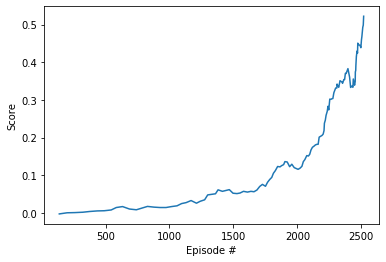

In [5]:
from __future__ import division
import matplotlib.pyplot as plt

%matplotlib inline
# plot the scores
x = np.array([episodes])
y = np.array([scores])
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(episodes, scores)
#plt.plot(np.arange(episodes), scores)
#plt.plot(np.arange(episodes),y)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()